## Lets look at the issues brought up in our meeting

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind', n_colors=5576)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['font.family'] = 'serif'
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

Targets in our dataframe: 500


/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


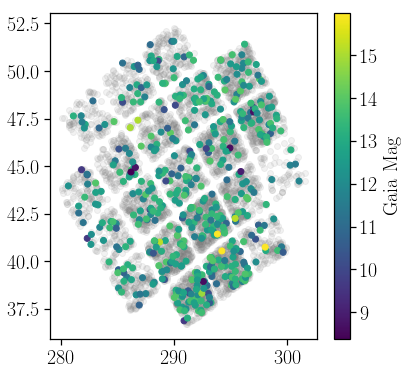

In [2]:
from sklearn.utils import shuffle
kdf = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18.csv')
nstars = 500
df = shuffle(kdf, random_state=24601).reset_index(drop=True)[:nstars]

print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(6,6))
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.GAIAmag, cmap='viridis')
f.colorbar(c, label=r"Gaia Mag")
plt.show()

## Plot a distribution of average separation for 500 stars

In [3]:
thetaij = np.sqrt(np.subtract.outer(df.ra.values, df.ra.values)**2 + np.subtract.outer(df.dec.values, df.dec.values)**2)

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


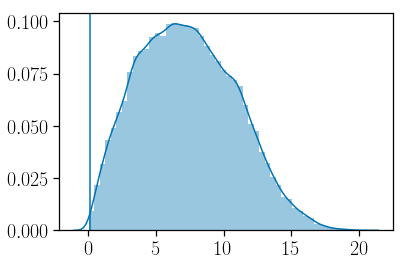

With 500 stars in our dataframe--
Number of separations below 0.125deg : 0


In [4]:
seps = np.tril(thetaij).flatten()
seps = seps[seps > 0.]
sns.distplot(seps)
plt.axvline(0.125)
plt.show()
print('With '+str(nstars)+' stars in our dataframe--')
print('Number of separations below 0.125deg : '+str(len(seps[seps<0.0125])))

## Does the Lindegren equation work as it should?
We can test this by checking whether the equation 
\begin{equation}
\frac{\rm{cov}_{ij}}{\sigma_i,\sigma_j}
\end{equation}
is between $0$ and $1$

In [5]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    thetaij = np.sqrt(np.subtract.outer(ra, ra)**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [6]:
p = [285.0*10**-6, 14.]
cov = kernel(kdf.ra.values, kdf.dec.values, kdf.parallax_error.values, p)

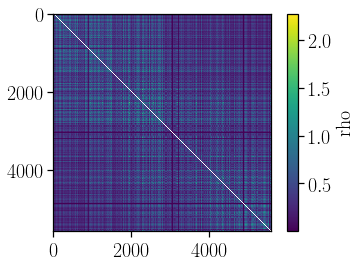

In [10]:
rho = cov / np.outer(kdf.parallax_error.values, kdf.parallax_error.values)
np.fill_diagonal(rho, np.nan)
c = plt.imshow(rho)
plt.colorbar(c, label='rho')
plt.show()

With 31091776 total correlations--
Number of rho values > 1. : 316479


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


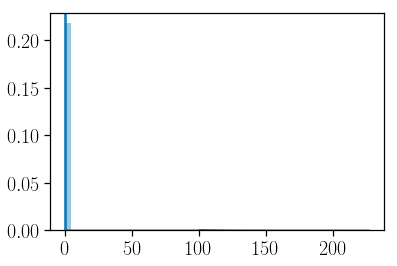

In [8]:
rhos = np.tril(rho).flatten()
sns.distplot(rhos[~np.isnan(rhos)])
plt.axvline(1.)
plt.axvline(0.)
print('With '+str(len(rhos))+' total correlations--')
print('Number of rho values > 1. : '+str(len(rhos[rhos>1.])))

This is curious, and absolutely should not be happening. Is there an issue with my Kernel?